# Chapter 7. Modern CNNs
- CNN ImageNet Competiton(2010 ~ )에서 많은 우수한 성과를 거두면서 인기를 누림
  - AlexNet
    - Large scale network
  - VGG
    - Repeating blocks of elements
  - NiN
    - Conv + Linear로 구성된 Block을 겹겹히 쌓은 구조
  - GoogLeNet
    - Parallel Concatenation
  - ResNet
    - Residual Connection
  - DenseNet 
    - Heavy to compute / Good Perf.
    
## Deep CNN (AlexNet)
- LeNet이 CNN을 알리는데에는 큰 역할을 했으나..
- 그럼에도 불고하고 다른 ML들(SVM 등)이 보다 높은 효율성을 보여 NN기술은 널리 보급되지 않음
- 하지만 Computer Vision 영역의 경우 이전 방법론은 많은 Manual Feature 추출 알고리즘에 의존했음
- 90년대 제한적인 가속기가 있었으나 Multi Layer / Multi Channel CNN을 다루기엔 불충분
- 또한 Neural Net의 주요 Trick들 SGD, Activation 함수, Paramter Init 등이 나오기 이전의 상태

### Learning Representaion
- 당시 Computer Vision 연구자들은 Learning Algorithm 자체보다 Feature의 추출이 결과에 훨씬 중요하다는 믿음을 가지고 있었음
- 반면 몇몇 연구자들은 이러한 Feature 자체도 Training 과정을 통해 학습될 수 있다고 믿었음
### Invention of AlexNet
- 2012년 ImageNet Challenge에서 최고 수준의 성능
- 가장 앞단의 Input Layer들은 일부 기존의 Craft 된 Feature Extractor와 매우 유사함이 발견됨
- 뒷단의 CNN Layer로 갈수록 보다 상위 개념들 (예를 들어 눈, 코, 입 -> 얼굴 -> 사람)의 표현들을 갖게됨
- 이러한 성과의 배경에는
  - Data 
    - ImageNet Dataset 공개 (@ '09)
  - Hardware 
    - 당시 Major Bottleneck이던 Convolution과 MatMul이 GPU를 통해 병렬 처리될 수 있음을 착안
    - 2 x NVIDIA 580 (3GB)를 이용
- Architecture
  - LeNet 보다 심층화된 CNN Layers
  - Relu의 사용 : 보다 단순호된 Activation
  - Regularization
    - Data Augmentation 
    - Dropout의 사용
   
    
  


  


In [1]:
import torch
from torch import nn
from d2l import torch as d2l

net = nn.Sequential(
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),  # 3 x 224 x 224  -> 288 x 54 x 54
    nn.MaxPool2d(kernel_size=3, stride=2),    # 288 x 54 x 54 -> 288 x 26 x 26                   
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),    # 288 x 26 x 26 -> 768 x 26 x 26
    nn.MaxPool2d(kernel_size=3, stride=2),                      # 768 x 26 x 26 -> 
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    nn.Linear(6400, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096,10))
X = torch.rand(size=(1,1,224,224))

for layer in net:
    X = layer(X)
    print(f'{layer.__class__.__name__} output shape : \t{X.shape}')

Conv2d output shape : 	torch.Size([1, 96, 54, 54])
ReLU output shape : 	torch.Size([1, 96, 54, 54])
MaxPool2d output shape : 	torch.Size([1, 96, 26, 26])
Conv2d output shape : 	torch.Size([1, 256, 26, 26])
ReLU output shape : 	torch.Size([1, 256, 26, 26])
MaxPool2d output shape : 	torch.Size([1, 256, 12, 12])
Conv2d output shape : 	torch.Size([1, 384, 12, 12])
ReLU output shape : 	torch.Size([1, 384, 12, 12])
Conv2d output shape : 	torch.Size([1, 384, 12, 12])
ReLU output shape : 	torch.Size([1, 384, 12, 12])
Conv2d output shape : 	torch.Size([1, 256, 12, 12])
ReLU output shape : 	torch.Size([1, 256, 12, 12])
MaxPool2d output shape : 	torch.Size([1, 256, 5, 5])
Flatten output shape : 	torch.Size([1, 6400])
Linear output shape : 	torch.Size([1, 4096])
ReLU output shape : 	torch.Size([1, 4096])
Dropout output shape : 	torch.Size([1, 4096])
Linear output shape : 	torch.Size([1, 4096])
ReLU output shape : 	torch.Size([1, 4096])
Dropout output shape : 	torch.Size([1, 4096])
Linear output sh

In [2]:
batch_size = 64
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

loss 0.273, train acc 0.899, test acc 0.894
375.7 examples/sec on cuda:0


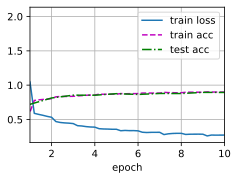

In [3]:
lr, num_epochs = 0.01, 10
d2l.train_ch6(net,train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## Network Using Blocks (VGG)
- CNN 설계에 대한 일종의 Template을 제시 
- 다수의 Transistor의 Logic Block을 이용하여 반도체를 설계하듯 
### VGG Block 
- 반복된 (Conv2D - ReLU)에 이어 MaxPool이 조합
### Architecture 
- 이러한 VGG Block의 다층 구조에 이어 FC Layer가 배치되는 구조

In [8]:
import torch
from torch import nn


def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels, 
                                kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    return nn.Sequential(*layers)

In [14]:
def vgg(conv_arch):
    conv_blks = []
    in_channels = 1
    
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels
    
    return nn.Sequential(*conv_blks, nn.Flatten(), 
                         nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(0.5),
                         nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
                         nn.Linear(4096,10))

conv_arch = ((1,64), (1,128), (2,256), (2,512), (2,512))

net = vgg(conv_arch)
X = torch.rand(size=(1,1,224,224))
for blk in net:
    X = blk(X)
    print(f'{blk.__class__.__name__} output shape: {X.shape}')

Sequential output shape: torch.Size([1, 64, 112, 112])
Sequential output shape: torch.Size([1, 128, 56, 56])
Sequential output shape: torch.Size([1, 256, 28, 28])
Sequential output shape: torch.Size([1, 512, 14, 14])
Sequential output shape: torch.Size([1, 512, 7, 7])
Flatten output shape: torch.Size([1, 25088])
Linear output shape: torch.Size([1, 4096])
ReLU output shape: torch.Size([1, 4096])
Dropout output shape: torch.Size([1, 4096])
Linear output shape: torch.Size([1, 4096])
ReLU output shape: torch.Size([1, 4096])
Dropout output shape: torch.Size([1, 4096])
Linear output shape: torch.Size([1, 10])


## Network in Network (NiN)
- LeNet / AlexNet / VGG의 Design 공통점
  - Image의 구조적 특징을 살려서 앞단의 Convolution과 Pooling을 통해 feature를 추출하고 뒷단에 FC를 배치한다는 것
- LeNet 대비 AlexNet / VGG의 발전은 이 Network 뒤쪽의 FC를 단순히 조금씩 확장한 것
- 완전히 다른 시도로 FC를 Network의 "조금 더 앞쪽"에 배치하는 방식을 시도
  - FC의 사용은 입력의 공간적 구조를 잃게 만들 수 있음
- 공간적 구조 특징을 유지하면서 FC와 같은 효과(MLP for each pixel)를 적용 -> **1 X 1 Conv**

  

### NiN Blocks
- Conv -> Activation -> Pixel wise MLP (Conv 1 x 1) -> Pixel wise MLP (Conv 1 x 1) 
- 하나의 Block이 마치 완결된 CNN의 구조를 갖는 것 같음 
  - Conv -> Activation -> FC -> FC .. 구조와 유사...

### NiN Model
- 또 하나의 특이한 점은 FC를 사용하지 않는다는 것.
- 마지막의 NiN Block Output channel이 class 갯수와 일치하도록 
- 이후 pooling을 이용하여 feature size를 1,1로 줄임
- Flatten으로 (n, class)으로 변환




In [1]:
import torch 
from torch import nn
from d2l import torch as d2l

def nin_block(in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU())

In [2]:
net = nn.Sequential(
    nin_block(1, 96, kernel_size=11, stride=4, padding=0),
    nn.MaxPool2d(3, stride=2),
    nin_block(96, 256, kernel_size=5, stride=1, padding=2),
    nn.MaxPool2d(3, stride=2),
    nin_block(256, 384, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(3, stride=2),
    nn.Dropout(0.5),
    nin_block(384, 10, kernel_size=3, stride=1, padding=1),
    nn.AdaptiveAvgPool2d((1,1)),
    nn.Flatten())

loss 0.250, train acc 0.909, test acc 0.905
314.1 examples/sec on cuda:0


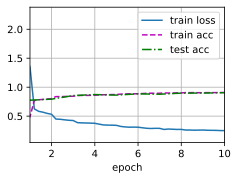

In [3]:
lr, num_epochs, batch_size = 0.1, 10, 32
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## Networks with Parallel Concatenation (GoogLeNet)
- 다양한 Kernel Size를 조합 시도
- 독창적인 구조 Inception Block의 고안

### Inception Blocks
- 4개의 Parallel path로 구성
- 3 for conv. layer with different kernel size for each, 1, 3, 5
- 마지막으로 channel count를 바꾸기 위한 1 x 1 conv layer 
- 각 layer의 output channel count를 hyperparamter tuning point로 많이 활용 

## Batch Normalization
- Deep Network(예를 들어 100 Layer 이상의..)의 학습 효율을 높일 수 있는 방법
### Training Deep Networks
- 아직 이론적으로 덜 정립되었음
- elementwise scale parameter와 shift parameter => input과 shape이 같음
- 각 element를 mean으로 빼고 variance로 나눔 => layer의 출력의 치우침이나 발산되지 않도록 방지
### Batch Normalizatino Layers
- Fully Connected와 Convolution layer간에 구현 방식의 차이가 존재함.
#### Fully Connected Layers
- Affine Transformation의 출력에 대해 Batch Norm 적용
- Y = Activation(BatchNorm(LinearFunction(X)))
#### Convolution Layers
- 위치는 Conv 뒤 그리고 Activiation 앞으로 위 FC와 유사
- Output이 Multi Channel인 경우 각 Channel별로 Batch Norm이 이루어짐.
#### Batch Normalization in Prediciont
- Prediction
  - train 시 구한 moving mean 그리고 moving variance를 그대로 사용
- Training
  - 해당 minibatch의 mean과 variance 값을 이용하여 moving mean과 moving variance 값을 update (momentum 계수만큼 곱해서..)
  
  


In [1]:
import torch 
from torch import nn
from d2l import torch as d2l 


def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    if not torch.is_grad_enabled():
        x_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2,4)
        if len(X.shape) == 2:
            mean = X.mean(dim = 0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            mean = X.mean(dim=(0,2,3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0,2,3), keepdim=True)
            
        X_hat = (X - mean) / torch.sqrt(var + eps)
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta
    return Y, moving_mean.data, moving_var.data

loss 0.259, train acc 0.904, test acc 0.873
39449.4 examples/sec on cuda:0


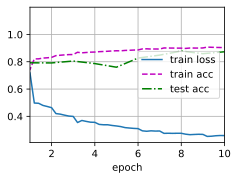

In [4]:
from torch import nn

net = nn.Sequential(
    nn.Conv2d(1,6, kernel_size=5), nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16 * 4 * 4, 120), nn.BatchNorm1d(120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
    nn.Linear(84,10)) 


lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())
    

### 논란
- Simpler Model이 더 Generalization에 유리하다는 이론적 기반이 부재
- Dropout 및 Weight Decay 역시 마찬가지 
- 논문에 batch norm이 효과적인 이유를 설명하는 과정에서의 Internal Covariate Shift (즉, Input의 Covariate Shift와 유사하게 Hidden Layer의 Covariate Shift와 유사한 개념으로)를 설명 (참고로 Andrew Ng도 동일한 용어를 사용)
- 하지만 엄밀한 의미에서 Covariate Shift가 아님
- 이것에 대한 논쟁이 반복되는데, 그냥 직관적인 이해를 돕는 정도로 받아 들이는 선정도로 타협

  


## Residual Network

- 더 심층적 Network를 만들 때 즉, Layer를 추가하는 것이 단순히 Network을 "다르게" 만드는 것이 아닌 더 "표현력"있는 모델이 되어야 의미가 있다. 

### Function Classes

- He et al.은 2016년 ResNet을 논문을 발표하면서 더 복잡한 모델이 항상 주어진 문제에 대한 이상적 모델(이하 Truth Model)에 근접하는 것을 보장하지 않음(표현력을 확장되지만 이상점으로 부터 멀어질 수 있음)을 착안
- 더 복잡한 (여기서는 더 심층의) 모델이 덜 복잡한 (얕은) 모델 대비 Truth Model에 근접하는 것을 보장하려면 심층 모델이 덜 복잡한 모델의 표현 범위를 포함할 수 있어야 한다.
- Layer를 증가 시킬 때 이전 Layer에 Identity function을 추가함으로써 이러한 아이디어를 구현

### Residual Blocks
- input과 output의 shape이 다를 경우 input을 output에 바로 add할 수 없으므로 1 x 1 convolution을 사용함



In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

class Residual(nn.Module):
    def __init__(self, input_channels, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels, 
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)
        
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels, kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
        
        
    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)
    
    
def resnet_block(input_channels, num_channels, num_res, first_block=False):
    blk = []
    for i in range(num_res):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk
       
        
        

In [2]:
## ResNet Model

b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                  nn.BatchNorm2d(64), nn.ReLU(),
                  nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

net = nn.Sequential(b1, b2, b3, b4, b5, 
                   nn.AdaptiveAvgPool2d((1,1)),
                   nn.Flatten(), nn.Linear(512, 10))


loss 0.013, train acc 0.997, test acc 0.888
338.1 examples/sec on cuda:0


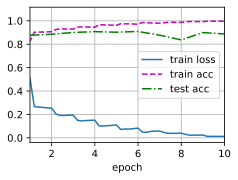

In [3]:
lr, num_epoch, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epoch, lr, d2l.try_gpu())

## Densely Connected Networks (DenseNet)

- layer의 입력이 출력에 concatenation 되어 그대로 전달되는 구조 
- 어떤 관점에서 ResNet과 비슷해 보이기도 하지만 ResNet은 elemwise add이고 DenseNet은 concat으로 차이가 있음 


### Dense Blocks

- BN -> Activation -> Conv2D의 독특한 구조를 지님



In [6]:
import torch
from torch import nn
from d2l import torch as d2l

def conv_block(input_channels, num_channels):
    return nn.Sequential(nn.BatchNorm2d(input_channels), nn.ReLU(),
                        nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1))

class DenseBlock(nn.Module):
    def __init__(self, num_convs, input_channels, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(num_channels * i + input_channels, num_channels))
        self.net = nn.Sequential(*layer)
        
    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            X = torch.cat((X,Y), dim=1)
        return X
    
    
    

In [7]:
blk = DenseBlock(2,3,10)
X = torch.rand(size=(4,3,8,8))
Y = blk(X)
Y.shape

torch.Size([4, 23, 8, 8])

### Transition Layers
- Dense Block이 반복되다 보면 concat의해 channel수가 기하 급수적으로 증가함. 자칫 복잡도가 너무커져 일반화 성능이 잘 안나올 수 있음. 
- 이를 적정 수준으로 유지하기 위해서 1 X 1 Conv layer를 사용

In [8]:
def transition_block(input_channels, num_channels):
    return nn.Sequential(nn.BatchNorm2d(input_channels), nn.ReLU(),
                        nn.Conv2d(input_channels, num_channels, kernel_size=1),
                        nn.AvgPool2d(kernel_size=2, stride=2))


In [9]:
blk = transition_block(23,10)
blk(Y).shape

torch.Size([4, 10, 4, 4])

### DenseNet Model

In [10]:
import torch
from torch import nn


b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                  nn.BatchNorm2d(64), nn.ReLU(),
                  nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

num_channels, growth_rate = 64, 32
num_convs_in_dense_block = [4,4,4,4]

blks = []

for i, num_convs in enumerate(num_convs_in_dense_block):
    blks.append(DenseBlock(num_convs, num_channels, growth_rate))
    num_channels += num_convs * growth_rate
    if i != len(num_convs_in_dense_block) - 1:
        blks.append(transition_block(num_channels, num_channels // 2))
        num_channels = num_channels // 2

net = nn.Sequential(b1, *blks,
                    nn.BatchNorm2d(num_channels), nn.ReLU(),
                   nn.AdaptiveAvgPool2d((1,1)),
                   nn.Flatten(),
                   nn.Linear(num_channels, 10))

loss 0.119, train acc 0.956, test acc 0.878
644.4 examples/sec on cuda:0


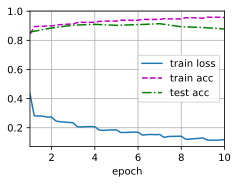

In [11]:
lr, num_epochs, batch_size = 0.1, 10, 64
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())